This program will be a continueation of the original cycling code. It will consider information for each gridpoint and be user input.

In [1]:
import warnings
#warnings.filterwarnings('ignore', 'numpy.dtype size changed')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptck
from datetime import datetime, timezone
import metpy.calc as mpcalc
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime as cftime
from metpy.plots import SkewT, StationPlot
from metpy.units import units
from metpy.calc import reduce_point_density
import scipy.ndimage
import time
import math
from siphon.simplewebservice.wyoming import WyomingUpperAir
from siphon.catalog import TDSCatalog
import calendar
from datetime import datetime, timedelta
import pytz

import os, sys
from bs4 import BeautifulSoup
from shapely.geometry.polygon import Polygon, LinearRing
from shapely.geometry import LineString
import logging
import urllib.request
import tkinter as tk

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import cftime as cftime
import matplotlib.path as mplPath
import re
import requests
import shapefile
from scipy import spatial
from shapely.geometry import shape
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from zipfile import ZipFile as zipf
from urllib.request import urlopen
from io import BytesIO


In [2]:
# Pull time from computer
d = datetime.utcnow()
#print(d)

# Specify format of date obtained from computer
#print(d.strftime('%Y-%m-%d %H:%M'))

# Save pieces to different variables

year = d.strftime('%Y')
month = d.strftime('%m')
day = d.strftime('%d')
hour = d.strftime('%H')
date = d.strftime('%Y%m%d%H')


In [3]:
cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_onedeg/catalog.xml')
#print(cat.latest)

#print(f'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/{cat.latest}')

In [4]:
# Read in Land Area Data
# data from: https://www.census.gov/geo/maps-data/data/gazetteer2017.html
ds2 = pd.read_csv('/home/emazan/public_html/cycle_safe/2017_Gaz_tracts_national.txt', skiprows=0, usecols=(0,4,6,7),delim_whitespace=True)
ds_mpstate = pd.read_csv('/home/emazan/public_html/cycle_safe/States.csv', index_col = 'State', skiprows=0)
# Read in model data:
ds = xr.open_dataset(f'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/{cat.latest}').metpy.parse_cf()


State_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 
              'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 
              'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA',
              'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

In [5]:
st_pt=np.array([[2,1183],[1183,1350],[1350,2876],[2876,3562],[3562,11619],[11619,12868],[12868,13701],[13701,13919],
               [14098,18343],[18343,20312],[20312,20663],[20663,20961],[20961,24084],[24084,25595],[25595,26420],
               [26420,27190],[27190,28305],[28305,29453],[29453,29811],[29811,31217],[31217,32695],[32695,35508],
               [35508,36846],[36846,37510],[37510,38903],[38903,39174],[39174,39706],[39706,40393],[40393,40688],
               [40688,42698],[42698,43197],[43197,48115],[48115,50311],[50311,50514],[50514,53467],[53467,54513],
               [54513,55347],[55347,58565],[58565,58809],[58809,59912],[59912,60134],[60134,61631],[61631,66897],
               [66897,67484],[67484,67668],[67668,69575],[69575,71033],[71033,71517],[71517,72926],[72926,73028]])
s_pt_df = pd.DataFrame(data=st_pt, columns=["start_list", "end_list"])
ds_mpstate1 = pd.merge(ds_mpstate , s_pt_df , on=ds_mpstate.index, how='outer')

In [6]:
time_list  = ds.time.values.astype('datetime64[ms]').astype('O')
run_times = [2,4,6,8,10,12,16,20,24]

In [7]:
def vtime_stamp(forecast_hour,  data_times):
    '''
    Inputs:
        forecast_hour is the forecast hour the timestamp is for
        local_tz is the local time zone as 'US/Central', 'US/Mountain', 'US/Pacific','US/Eastern' 
        data_times is list of time values as type 'datetime64[ms]'
    Returns:
        timestamp in '02/09/2020 06:00 AM CST ' format.
    '''
    
    local = pytz.timezone('US/Central') # 'US/Central', 'US/Mountain', 'US/Pacific','US/Eastern' 
    
    def utc_to_local(utc_dt):
        return utc_dt.replace(tzinfo=timezone.utc).astimezone(tz=None)

    def utc_to_local(utc_dt):
    # get integer timestamp to avoid precision lost
        timestamp = calendar.timegm(utc_dt.timetuple())
        local_dt = datetime.fromtimestamp(timestamp)
        assert utc_dt.resolution >= timedelta(microseconds=1)
        return local_dt.replace(microsecond=utc_dt.microsecond)

    def utc_to_local(utc_dt):
        local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local)
        return local.normalize(local_dt) # .normalize might be unnecessary

    def aslocaltimestr(utc_dt):
        return utc_to_local(utc_dt).strftime('%m/%d/%Y %I:%M %p %Z ')
    
    forhr = (aslocaltimestr(data_times[forecast_hour]))
    
    return forhr

vtime_stamp(4, time_list)  

'05/11/2020 01:00 PM CDT '

In [8]:
#print(time_list[0].hour)
#print(time_list[0])
for_hr = time_list[1].strftime("%m/%d/%Y, %H:%M:%S")
for_hr1 = time_list[2].strftime("%m/%d/%Y, %H:%M:%S")

In [9]:
# Pull data from SPC Outlook:

# opening the zip file in READ mode
data = urlopen('https://www.spc.noaa.gov/products/outlook/day1otlk-shp.zip') #operationalize
with zipf(BytesIO(data.read()), 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    zip.extractall(path='outlooks/')

#cart_shape = Reader('/home/emazan/Downloads/SPC_Outlooks/day1otlk-shp(1)/day1otlk_cat.shp')
cart_shape = Reader('/home/emazan/cycle_proj/outlooks/day1otlk_cat.shp')

#day 2:
data2 = urlopen('https://www.spc.noaa.gov/products/outlook/day2otlk-shp.zip') #operationalize
with zipf(BytesIO(data2.read()), 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    zip.extractall(path='outlooks/')
cart_shape2 = Reader('/home/emazan/cycle_proj/outlooks/day2otlk_cat.shp')

#day 3:
data3 = urlopen('https://www.spc.noaa.gov/products/outlook/day3otlk-shp.zip') #operationalize
with zipf(BytesIO(data3.read()), 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    zip.extractall(path='outlooks/')
cart_shape3 = Reader('/home/emazan/cycle_proj/outlooks/day3otlk_cat.shp')

File Name                                             Modified             Size
day1otlk_cat.shp                               2020-05-11 13:00:00         3436
day1otlk_hail.shp                              2020-05-11 13:00:04          984
day1otlk_sighail.shp                           2020-05-11 13:00:04          220
day1otlk_sigtorn.shp                           2020-05-11 13:00:02          220
day1otlk_sigwind.shp                           2020-05-11 13:00:04          220
day1otlk_torn.shp                              2020-05-11 13:00:00          300
day1otlk_wind.shp                              2020-05-11 13:00:02         1436
day1otlk_cat.shx                               2020-05-11 13:00:00          124
day1otlk_hail.shx                              2020-05-11 13:00:04          116
day1otlk_sighail.shx                           2020-05-11 13:00:04          108
day1otlk_sigtorn.shx                           2020-05-11 13:00:02          108
day1otlk_sigwind.shx                    

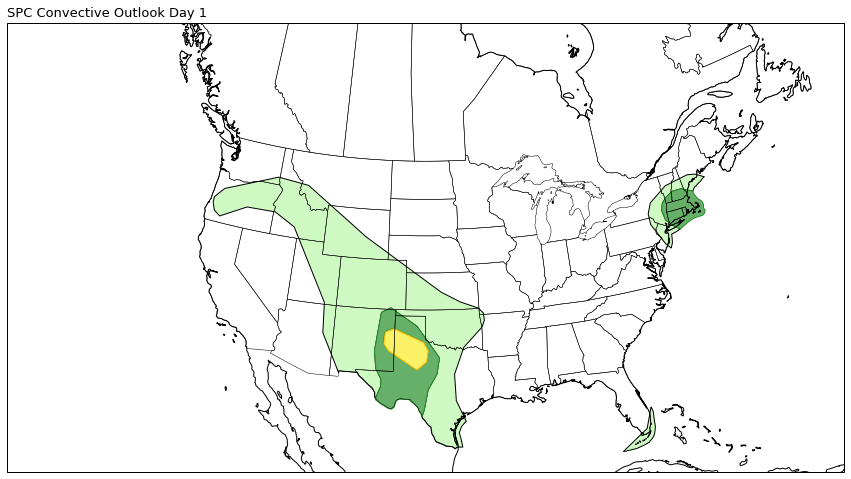

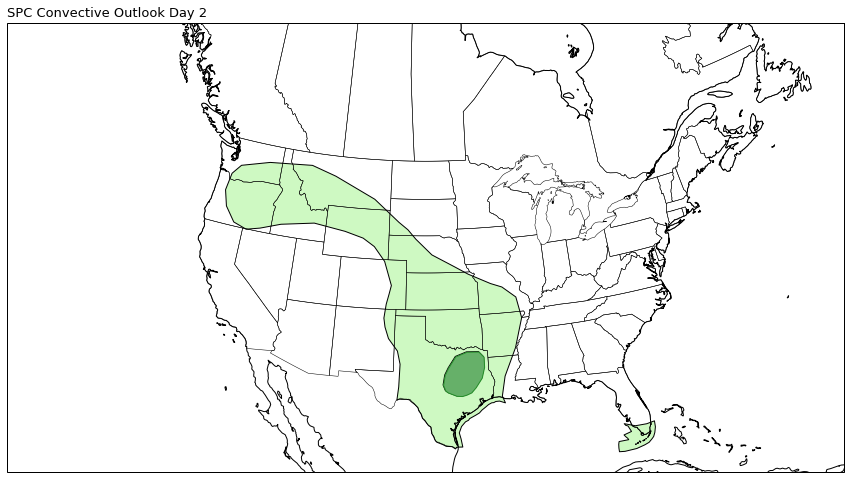

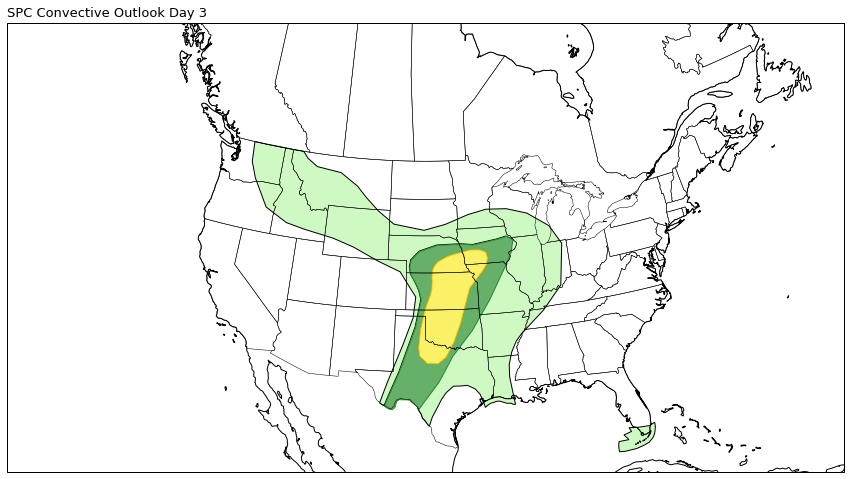

In [10]:
fname = r'/home/emazan/cycle_proj/outlooks/day1ot1k_cat.shp'
fname2 = r'/home/emazan/cycle_proj/outlooks/day1ot2k_cat.shp'
fname3 = r'/home/emazan/cycle_proj/outlooks/day1ot3k_cat.shp'
# Map example 2
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.LambertConformal(central_latitude=40, central_longitude=-100)
fig = plt.figure(figsize=(15,15))
# Set up figure

ax = plt.axes(projection=mapcrs)
fcolors = {'TSTM': '#cef9c2', 'MRGL': '#66b069', 'SLGT':'#faf166','ENH': '#e8ad63', 'MDT':'#e04c4c', 'HI':'#ff62e7'}
colors = {'TSTM': 'black', 'MRGL': '#268f2a', 'SLGT':'#ffbd00', 'ENH': '#ff9817', 'MDT':'#b20000', 'HI':'#e400c1'}
try:
    for shape in cart_shape.records():
        shape_feature = ShapelyFeature(shape.geometry, ccrs.PlateCarree(), 
                                       edgecolor= colors[shape.attributes['LABEL']], 
                                       facecolor = fcolors[shape.attributes['LABEL']])
        ax.add_feature(shape_feature)
except KeyError:
    for shape in cart_shape.records():
        shape_feature = ShapelyFeature(shape.geometry, ccrs.PlateCarree())
        

ax.set_extent([-135, -65, 20, 55], ccrs.Geodetic())
#ax.add_feature(shape_feature, facecolor='green')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
plt.title('SPC Convective Outlook Day 1', loc='Left', fontsize=13)

plt.savefig('/home/emazan/public_html/cycle_safe/spc_d1',bbox_inches='tight')



############################
# Map example 2
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.LambertConformal(central_latitude=40, central_longitude=-100)
fig = plt.figure(figsize=(15,15))
# Set up figure

ax = plt.axes(projection=mapcrs)
fcolors = {'TSTM': '#cef9c2', 'MRGL': '#66b069', 'SLGT':'#faf166','ENH': '#e8ad63', 'MDT':'#e04c4c', 'HI':'#ff62e7'}
colors = {'TSTM': 'black', 'MRGL': '#268f2a', 'SLGT':'#ffbd00', 'ENH': '#ff9817', 'MDT':'#b20000', 'HI':'#e400c1'}
try:
    for shape in cart_shape2.records():
        shape_feature = ShapelyFeature(shape.geometry, ccrs.PlateCarree(), 
                                       edgecolor= colors[shape.attributes['LABEL']], 
                                       facecolor = fcolors[shape.attributes['LABEL']])
        ax.add_feature(shape_feature)
except KeyError:
    for shape in cart_shape2.records():
        shape_feature = ShapelyFeature(shape.geometry, ccrs.PlateCarree())
        

ax.set_extent([-135, -65, 20, 55], ccrs.Geodetic())
#ax.add_feature(shape_feature, facecolor='green')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
plt.title('SPC Convective Outlook Day 2', loc='Left', fontsize=13)

plt.savefig('/home/emazan/public_html/cycle_safe/spc_d2',bbox_inches='tight')



#################################3
# Map example 2
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.LambertConformal(central_latitude=40, central_longitude=-100)
fig = plt.figure(figsize=(15,15))
# Set up figure

ax = plt.axes(projection=mapcrs)
fcolors = {'TSTM': '#cef9c2', 'MRGL': '#66b069', 'SLGT':'#faf166','ENH': '#e8ad63', 'MDT':'#e04c4c', 'HI':'#ff62e7'}
colors = {'TSTM': 'black', 'MRGL': '#268f2a', 'SLGT':'#ffbd00', 'ENH': '#ff9817', 'MDT':'#b20000', 'HI':'#e400c1'}
try:
    for shape in cart_shape3.records():
        shape_feature = ShapelyFeature(shape.geometry, ccrs.PlateCarree(), 
                                       edgecolor= colors[shape.attributes['LABEL']], 
                                       facecolor = fcolors[shape.attributes['LABEL']])
        ax.add_feature(shape_feature)
except KeyError:
    for shape in cart_shape3.records():
        shape_feature = ShapelyFeature(shape.geometry, ccrs.PlateCarree())
        

ax.set_extent([-135, -65, 20, 55], ccrs.Geodetic())
#ax.add_feature(shape_feature, facecolor='green')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
plt.title('SPC Convective Outlook Day 3', loc='Left', fontsize=13)

plt.savefig('/home/emazan/public_html/cycle_safe/spc_d3',bbox_inches='tight')

In [11]:
def fwarn(x):

    q = np.zeros(x.shape)

    # for x <= 2 
    #'Vey low potential for large fire growth.'
    ind = np.where(x <= 2)
    q[ind] = 0

    # for 2 < x < 4 
    #'Vey low potential for large fire growth.'
    ind = np.where((x > 2)& (x < 4))
    q[ind] = 1.01
    
    # for x = 4 
    #'Low potential for large fire growth.'
    ind = np.where(x == 4)
    q[ind] = 3.01
    
    # for x = 5
    #'Moderate potential for large fire growth.'
    ind = np.where(x == 5)
    q[ind] = 4.01

    # for x = 6
    #'High potential for large fire growth.'
    ind = np.where(x == 6)
    q[ind] = 5.01

    # for x = 999
    #'No Fire Data'
    ind = np.where(x == 999)
    q[ind] = 0


    return q

def viswarn(x):

    q = np.zeros(x.shape)

    #''Clear. Visibility is not a threat to cyclists''
    ind = np.where((x >= 10) & (x < 999))
    q[ind] = 0.01

    #'Visibility is not a major threat to cyclists.'
    ind = np.where((x >= 7)& (x < 10))
    q[ind] = 1.01
    
    #'Visibility may be a threat to cyclists.'
    ind = np.where((x >= 5) & (x < 7))
    q[ind] = 2.01
    
    # for x = 5
    #'Visibility is a threat to cyclists.'
    ind = np.where((x >= 3) & (x < 5))
    q[ind] = 4.01

    # for x = 6
    #'Visibility is a major threat to cyclists.'
    ind = np.where(x < 3)
    q[ind] = 5.01

    # for x = 999
    #'No Data'
    ind = np.where(x == 999)
    q[ind] = 0


    return q



#determine visibility danger for each point:

def pcpwarn(x):

    q = np.zeros(x.shape)

    #'Precipitation is not a threat to cyclists'
    ind = np.where((x  < 0.01))
    q[ind] = 0

    #'Precipitation is not a major threat to cyclists'
    ind = np.where((x < 0.1)& (x >= 0.01))
    q[ind] = 1.01
    
    #'Precipitation may be a threat to cyclists. Bike with caution.'
    ind = np.where((x < 1.0) & (x >= 0.1))
    q[ind] = 2.01
    
    # for x = 5
    #'Precipitation is a threat to cyclists. Cycling is not recommended'
    ind = np.where((x <= 5.0) & (x>= 1.0))
    q[ind] = 3.01

    # for x = 6
    #'Precipitation is a major threat to cyclists. Cycling is not recommended'
    ind = np.where(x >5.0)
    q[ind] = 4.01

    # for x = 999
    #'No Data'
    ind = np.where(x == 999)
    q[ind] = 0


    return q


def h_index(x):

    q = np.zeros(x.shape)

    #'High temperatures make for potentially hazardous biking'
    ind = np.where((x < 91) & (x >= 80))
    q[ind] = 1.01
    
    #'High temperatures make for potentially hazardous biking.'
    ind = np.where((x < 103) & (x >= 91))
    q[ind] = 2.01
    
    #'High temperatures make for  hazardous biking'
    ind = np.where((x < 120)& (x >= 103))
    q[ind] = 3.01

    #'Dangerously high heat index'
    ind = np.where(x >= 120)
    q[ind] = 4.01

    # for x = 999
    #'No Data' or no heat threat
    ind = np.where((x == 999) | (x < 80))
    q[ind] = 0


    return q

# Define chill accounting for the average speed of a bicyclist:

def Wind_Chill(T, V):
    ''' This function calculates the wind chill a cyclist would experience assuming an average speed of 15mph.
    
    Inputs:
     T is the temperature at the surface in F
     V is the wind speed in mph
 
     
     Returns:
      windchill is the temperature the cyclist feels
 
    '''    
    
    a = 0.6215*T
    b = ((V+15)**0.16)
    c = 0.4275*T
    d = ((V+15)**0.16)
    windchill = 35.74 + a - (35.75*b) + c*d
    
    
    return (windchill)

# determine safety risks regarding wind chill

def wind_index(x):

    q = np.zeros(x.shape)

    #'low wind chill. Dress warm and bike with caution'
    ind = np.where((x<45) & (x >=32))
    q[ind] = 1.01
    
    #'Dangerously low wind chill. Biking is not recomended and is not safe for etended periods time.'
    ind = np.where((x<32) & (x >=0))
    q[ind] = 2.01
    
    #'Dangerously low wind chill. Biking is not recomended and is not safe for more than 30 minutes at a time'
    ind = np.where((x >=-17)& (x <0))
    q[ind] = 3.01

    #'Dangerously low wind chill. Biking is not safe'
    ind = np.where(x <-17)
    q[ind] = 4.01

    # for x = 999
    #'No Data' or no cold threat
    ind = np.where((x == 999) | (x > 45))
    q[ind] = 0


    return q

def cloudcover_index(x):

    #Clear skies allow virtually 100% of UV to pass through, scattered clouds transmit 89%, broken clouds transmit 73%, and overcast skies transmit 31%.
    q = np.zeros(x.shape)
    #clear
    ind = np.where((x>=0) & (x < 10))
    q[ind] = 1
    
    #scattered clouds
    ind = np.where((x>=10) & (x <50))
    q[ind] = .89
    
    #broken clouds
    ind = np.where((x >=50)& (x < 90))
    q[ind] = .73

    #overcast
    ind = np.where(x >=90)
    q[ind] = .31

    return q





In [12]:
# Create if statement/for loop to solve for the solar zenith angle then take the cosine.

#Create Definitition to solve for sunangle. This definition is from: 
#https://stackoverflow.com/questions/8708048/position-of-the-sun-given-time-of-day-latitude-and-longitude

def sunPosition(lat, long, time_list):
    
#    for step in range(TimeStep):
# Get Julian date - 2400000

    day = int(time_list.strftime('%j'))
    hour = (time_list).hour
    delta = (time_list).year - 1949
    leap = delta / 4
    jd = 32916.5 + delta * 365 + leap + day + hour / 24

    # The input to the Atronomer's almanach is the difference between
    # the Julian date and JD 2451545.0 (noon, 1 January 2000)
    t = jd - 51545        

        
    # Latitude [rad]
    lat_rad = math.radians(lat)

    # Ecliptic coordinates

    # Mean longitude
    mnlong_deg = (280.460 + .9856474 * t) % 360

    # Mean anomaly
    mnanom_rad = math.radians((357.528 + .9856003 * t) % 360)

    # Ecliptic longitude and obliquity of ecliptic
    eclong = math.radians((mnlong_deg + 1.915 * math.sin(mnanom_rad) + 0.020 * math.sin(2 * mnanom_rad)) % 360)
    oblqec_rad = math.radians(23.439 - 0.0000004 * t)

    # Celestial coordinates
    # Right ascension and declination
    num = math.cos(oblqec_rad) * math.sin(eclong)
    den = math.cos(eclong)
    ra_rad = math.atan(num / den)
    if den < 0:
        ra_rad = ra_rad + math.pi
    elif num < 0:
        ra_rad = ra_rad + 2 * math.pi
    dec_rad = math.asin(math.sin(oblqec_rad) * math.sin(eclong))

    # Local coordinates
    # Greenwich mean sidereal time
    gmst = (6.697375 + .0657098242 * t + hour) % 24
    # Local mean sidereal time
    lmst = (gmst + long / 15) % 24
    lmst_rad = math.radians(15 * lmst)

    # Hour angle (rad)
    ha_rad = (lmst_rad - ra_rad) % (2 * math.pi)

    # Elevation
    el_rad = math.asin(math.sin(dec_rad) * math.sin(lat_rad) + math.cos(dec_rad) * math.cos(lat_rad) * math.cos(ha_rad))

    # Azimuth
    az_rad = math.asin(
        - math.cos(dec_rad) * math.sin(ha_rad) / math.cos(el_rad))

    if (math.sin(dec_rad) - math.sin(el_rad) * math.sin(lat_rad) < 0):
        az_rad = math.pi - az_rad
    elif (math.sin(az_rad) < 0):
        az_rad += 2 * math.pi

    return math.degrees(el_rad)

In [13]:
def ClearSky(CosZenith, Ozoneval):
    '''
    Clear sky uv index:
       UVI approximately 12.5mu(o)(2.42)(Omega/300)(-1.23) where mu(o) is the cosine of the solar zenith angle and Omega is
       the total vertical ozone column (in Dobson Units, DU). 
       
       UVI ~ 12.5(mu(0))^2.42 * (Omega/300)^(-1.23)
 
   '''
    
    return (12.5*((math.radians(CosZenith))**2.42))*((Ozoneval/300)**(-1.23))



def EL_INFL(surface_el):
    '''UV intensity increases about 6% per kilometer elevation above sea level
        https://www.epa.gov/sunsafety/calculating-uv-index-0 
    '''
    
    return ((surface_el)*.06 + 1)



def UV_calc (INFL_arr, CSI_arr):
    
    return INFL_arr*0.7*CSI_arr

# determine safety risks regarding wind chill

def UV_index(x):

    q = np.zeros(x.shape)

    #'Moderate. Seek shade during midday'
    ind = np.where((x<6) & (x >=3))
    q[ind] = 1.01
    
    #'High threat. Limit sun from 11am to 5pm.'
    ind = np.where((x<8) & (x >=6))
    q[ind] = 2.01
    
    #'Very High sun threat. Avoid sun from 11am to 5pm'
    ind = np.where((x >=8)& (x <10))
    q[ind] = 3.01

    #'Extreme sun threat. Do not go outdoors'
    ind = np.where(x > 10)
    q[ind] = 4.01

    # for x = 999
    #'No Data' or Low sun threat
    ind = np.where((x<3))
    q[ind] = 0


    return q



In [14]:
def SPC (nday):
    'determines what catagorical outlook to use'
    run_day = time_list[run_times[0]].day
    if (nday == run_day):
        T_warn = TSarray
    elif (nday == run_day+1):
        T_warn = TSarray2
    elif (nday == run_day+2):
        T_warn = TSarray3
    else:
        T_warn = TSarray3
        
    return T_warn



def SPC2d (nday):
    'determines what catagorical outlook to use'
    run_day = time_list[run_times[0]].day
    if (nday == run_day):
        T2d = TS2d1
    elif (nday == run_day+1):
        T2d = TS2d2
    elif (nday == run_day+2):
        T2d = TS2d3
    else:
        T2d = TS2d3        
    
    return T2d
#SPC(time_list[run_times[6]].day)

In [15]:
# Create definition for Safe reading regarding the area of land in square miles. Issue a warning value
# based on land area data when convection is possible. The more land there is, the less safe to bike 
# when there is a threat for severe are hazardous weather. The value '1' will be issued for areas with 
# lower land area per square mile, implying that there are more buildings present. The value '1' will 
# be issued for areas with little to no buildings.

def biking(land_area):
    ''' This function calculates the Safe rating for cycling in the area.
    
    Inputs:
     land_area is the area land per square mile at a given latitude and longitude
  
     Returns:
      SAFE index provides a scale to indicate landarea threat
     
    '''    
    b = np.zeros(len(land_area)) #create an array of zeros to hold the result
    safe = (b.reshape(len(land_area)))# reshape b to make sure its a (1,10) array and not (10,)
    for i in range(len(land_area)):
        if (land_area[i]<= 10): # land area less than 1 corrisponds to an urban area
            safe[i] = 1
        elif (10 < land_area[i] < 30): # land area less than 30 corrisponds to a small, smaller suburban town
            safe[i] = 2
        elif (30 < land_area[i] < 70): # land area less than 70 corrisponds to a town with a church, school, and some stores
            safe[i] = 3
        elif (70 < land_area[i]< 170): # land area less than 170 corrisponds to a rural area with some houses and a convient store
            safe[i] = 4
        elif (land_area[i]>= 170): # land area greater than 170 corrisponds to maybe a barn or 2 if you are lucky
            safe[i] = 5
            
    # land area coorispondence is based off of a comparison to the land area size indicated by the data and a google search of the town and the number of buildings.

    return (safe)

    


In [16]:
# bike index will take multiple definitions because being assessed at each land area point, but assessing with the gfs points
#so, first need to asses weather hazards:

def biketot(heatwarn, wndchillwarn, viswarn, prcpwarn, uviwarn, firewarn, TSwarn):
    ''' This function calculates the Safe rating for cycling in the area.
    Inputs:
     heatwarn is the heat index threat (0-4)
     wndchillwarn is the windchill threat (0-4) 
     viswarn is visibility threat (0-4) 
     prcpwarn is precipitation threat (0-4) 
     uviwarn is uv threat (0-4) 
     TSwarn is thunder storm threat (0-6)
     firewarn is the Fire index threat (0-4)
    
    Returns:
     SAFE index provides a scale to indicate if biking is safe
     
    -------------------------------------------------------------------
     Each factor is multiplied based on risk associated with it.  
     
     Heat index threat is multiplied by 2 because cyclists can take 
         percaution by staying hydrated and taking breaks. However, 
         the threat is most prominant while riding.
     
     Windchill threat is multiplied by 2 because cyclists can take 
         percaution by wearing layers and taking breaks to warm up. 
         However, the threat is most prominant while riding.
     
     Visibility threat is multiplied by 4 because riding on roads 
         becomes unsafe. Vehicles become more of a threat when 
         visibility is impaired. Additionally, curved roads or sharp
         turns may go unnoticed until it is too late.
     
     Precipitation threat is multiplied by 3 because water on roads 
         and impaired visibility is dangerous to cyclists. However,
         cyclists are generally safe if they get off their bikes 
         and move away from the road. This is as long as they are 
         aware of the potential for flash floods, land slides, and 
         other rain prompted threats.
         
     UV threat threat is multiplied by 1 as cyclists can take 
         percaution by covering their skin and it does not put their 
         lives at risk as they cycle, unless paired with a high 
         heat index. 
         
     Thunder storm threat is multiplied by 5 because lightning and 
         severe weather can be life threatening. Cycling during a 
         thunderstorm is a major risk and should be avoided at all
         costs.
         
     Fire threat is multiplied by 1 as it can be planned for and avoided.

     --------------------------------------------------------------------     
    '''    
    total = []
    for i in range(len(heatwarn)):
        add = (2*(heatwarn[i]) + 2*(wndchillwarn[i]) + 4*(viswarn[i]) + 3*(prcpwarn[i]) + 1*(uviwarn[i])+ 1*(firewarn[i])+ 5*(TSwarn[i]))
        total.append(add)
   
    return (total)

In [37]:
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[35])


#g= 13
# Subset data for state
# change print format becasue if statement had trouble reading the array as exponetials
#ds_mpstate1
for g in [6]:
    np.set_printoptions(formatter={'float_kind':'{:f}'.format})
    state_landar= ds2[ds_mpstate1.start_list[g]:ds_mpstate1.end_list[g]]
    land = state_landar.ALAND_SQMI[:]
    landar=np.asarray(land[0:]) 


    map_ext = tuple([float(s) for s in ds_mpstate.mapCoords[g].split(',')])
    map_size = tuple([float(s) for s in ds_mpstate.mapSize[g].split(',')])
    
    # Subset data for ND:
    lats  = ds.lat.sel(lat = slice(map_ext[3]+10, map_ext[2]-5))
    lons  = ds.lon.sel(lon = slice(360-np.abs(map_ext[0]-10), 360-np.abs(map_ext[1]+6)))
    lat = lats.values.tolist()
    lon = lons.values.tolist()
    # Create 2d coords:
    lon2d,lat2d = np.meshgrid(lons,lats)
    lat3 = lat2d.ravel().tolist()
    lon3 = lon2d.ravel().tolist()

    
    # Use Haines index as fire weather index:
    latslice = slice(map_ext[3]+10, map_ext[2]-5)
    lonslice = slice(360-np.abs(map_ext[0]-10), 360-np.abs(map_ext[1]+6))
    rows = len(lat)
    cols = len(lon)

    nlat = ds.lat.sel(lat=latslice).count().values
    nlon = ds.lon.sel(lon=lonslice).count().values

    tfire_ar = np.empty((len(run_times), nlat*nlon))

    for i,k in enumerate(run_times):
        fire = ds.Haines_index_surface.sel(lat = latslice, lon = lonslice)[k]
        fr = fire.values
        fr[np.isnan(fr)] = 999
        f = fr.ravel()
        tfire_ar[i, :] = f
        fire3d = np.reshape(tfire_ar, (len(run_times),rows, cols))
    f_warn = fwarn(fire3d)
    
##################Visibility data:
    tvis_ar = np.empty((len(run_times), nlat*nlon))

    for i,k in enumerate(run_times):
        vis = ds.Visibility_surface.sel(lat = latslice, lon = lonslice)[k]
        vi = vis.values
        vi[np.isnan(vi)] = 999
        #convert vis data from meters to miles
        vs= vi/1609.344
        v = vs.astype(int).ravel()
        tvis_ar[i, :] = v
        vis3d = np.reshape(tvis_ar, (len(run_times),rows, cols))
    v_warn = viswarn(vis3d)
        
##################Precip data:    
    tpcp_ar = np.empty((len(run_times), nlat*nlon))

    for i,k in enumerate(run_times):
        TP= ds.Total_precipitation_surface_Mixed_intervals_Accumulation.sel(lat = latslice, lon = lonslice)[k]
        pr = TP.values 
        pr[np.isnan(pr)] = 999
        TPinch = (pr[:])/(25.4)
        pre = TPinch.ravel()
        tpcp_ar[i, :] = pre
        pcp3d = np.reshape(tpcp_ar, (len(run_times),rows, cols))
    pcp_warn = pcpwarn(pcp3d)
    
    # surface temp data
    T = ds.Temperature_surface.sel(lat = slice(60, 40), lon = slice(360-115, 360-90))[0]
    Tem = T.values #Temp in K
    #Convert to F:
    C = Tem - 273.15
    TempF = (9.0/5.0)*C + 32
    Tempt = TempF.ravel()
    Temp = list(Tempt)
    Temp = [int(x) for x in Temp]
    TC = C.ravel()

    #Convert to F:
    TF = Tem - 273.15
    TempF = (9.0/5.0)*TC + 32
    Tempt = TempF.ravel()
    Temp = list(Tempt)
    Temp = [int(x) for x in Temp]

    #max 6hr temp:
    Hi = ds.Maximum_temperature_height_above_ground_Mixed_intervals_Maximum.sel(lat = slice(60, 40), lon = slice(360-115, 360-90))[0]
    H = Hi.values
    #Convert to F:
    HC = H - 273.15
    HTempF = (9.0/5.0)*HC + 32
    HTempt = HTempF.ravel()
    HTemp = list(HTempt)
    HTemp = [int(x) for x in HTemp]

    HTemp

    #min 6hr temp:
    Lo = ds. Minimum_temperature_height_above_ground_Mixed_intervals_Minimum.sel(lat = slice(60, 40), lon = slice(360-115, 360-90))[0]
    L = Lo.values
    #Convert to F:
    LC = L - 273.15
    LTempF = (9.0/5.0)*LC + 32
    LTempt = LTempF.ravel()
    LTemp = list(LTempt)
    LTemp = [int(x) for x in LTemp]
    

######################## surface temp data
    tempc_ar = np.empty((len(run_times), nlat*nlon))
    tempf_ar = np.empty((len(run_times), nlat*nlon))
    tRH_ar = np.empty((len(run_times), nlat*nlon))
    heatidx_ar = np.empty((len(run_times), nlat*nlon))

    for i,k in enumerate(run_times):
        T = ds.Temperature_surface.sel(lat = latslice, lon = lonslice)[k]
        Tem = T.values 
        C = Tem - 273.15
        tc = C.ravel()
        Temptc = C.astype(int).ravel()
        tempc_ar[i, :] = Temptc
        tempc3d = np.reshape(tempc_ar, (len(run_times),rows, cols))
      #Convert to F:  
        TempF = (9.0/5.0)*tc + 32
        Tempt = TempF.astype(int).ravel()
        tempf_ar[i, :] = Tempt
        tempf3d = np.reshape(tempf_ar, (len(run_times),rows, cols))


       # Relative Humidity data: 
        RelH = ds.Relative_humidity_height_above_ground.sel(lat = latslice, lon = lonslice)[k]
        RH = RelH.values 
        REH = RH.ravel()
        tRH_ar[i, :] = REH
        RH3d = np.reshape(tRH_ar, (len(run_times),rows, cols))

        #calc heat index:
        TC = C.ravel()*units.celsius
        rhp = RH.ravel()*units.percent
        for j in range(len(TC)):
            if (tc[j]>0):
                heatidx_ar[i, :] = float((mpcalc.heat_index(TC[j],rhp[j], mask_undefined=False)).magnitude)
            else:
                heatidx_ar[i, :] = 0
        heatidx3d = np.reshape(heatidx_ar, (len(run_times),rows, cols))
    heat_warn = h_index(heatidx3d)

##################### Wind
    wind_ar = np.empty((len(run_times), nlat*nlon))
    #wind gust data:
    for i,k in enumerate(run_times):
        W = ds.Wind_speed_gust_surface.sel(lat = latslice, lon = lonslice)[k]
        wind = W.values 
        #convert winds from m/s to mph:
        wndmph = (2.236936)*wind
        wd = wndmph.ravel()
    #calc windchill
        WndCh = Wind_Chill(Tempt,wd)
        wind_ar[i, :] = WndCh
        wind3d = np.reshape(wind_ar, (len(run_times),rows, cols))
    cold_warn = wind_index(wind3d)
    
    
############################################################################################
# UV index:
#thickness of the ozone layer, cloud cover, time of year, & elevation 
#for sake of simplicity, a new index will be generated to omit irradance.
# https://www.epa.gov/sunsafety/calculating-uv-index-0
# https://www.esrl.noaa.gov/gmd/grad/neubrew/docs/UVindex.pdf
# https://escholarship.org/uc/item/5925w4hq


### https://www.ncbi.nlm.nih.gov/pubmed/18028230
# "An approximate formula for the UV Index (UVI) under cloud-free, unpolluted, low surface albedo conditions
# is: UVI approximately 12.5mu(o)(2.42)(Omega/300)(-1.23) where mu(o) is the cosine of the solar zenith angle and Omega is
# the total vertical ozone column (in Dobson Units, DU). The dependence on mu(o) and Omega is based on a simple physical 
# model of biologically weighted atmospheric transmission in the UV-B and UV-A spectral bands, with coefficients tuned 
# to a detailed radiative transfer model, and is accurate to 10% or better over 0-60 degrees and 200-400 DU. Other 
# factors (clouds, haze, ground, etc.) mostly conserve this dependence and scale simply.""

# Create if statment regarding cloud cover percent. If Cloud cover is zero (or near 0) then continue with the process. 
# Create if statement/for loop to solve for the solar zenith angle then take the cosine.
# Then loop 12.5mu(0)(2.42)(omega/300)(-1.23) where omega = total ozone entire atmos single laer in Du's

# if cloud cover is greater than 0%, additional calculations will be required.

    ozone_ar = np.empty((len(run_times), nlat*nlon))
    CC_ar = np.empty((len(run_times), nlat*nlon))
    elevation_ar = np.empty((len(run_times), nlat*nlon))
    sunPo_ar = np.empty((len(run_times), nlat*nlon))

    for i,k in enumerate(run_times):
        # ozone data:
        Oz = ds.Total_ozone_entire_atmosphere_single_layer.sel(lat = latslice, lon = lonslice)[k]
        ozon = Oz.values
        Ozone = ozon.ravel()
        ozone_ar[i, :] = Ozone
        Ozone3d = np.reshape(ozone_ar, (len(run_times),rows, cols))

        # cloud cover data:
        cc = ds. Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average.sel(lat = latslice, lon = lonslice)[k]
        clcvr = cc.values
        cdcvr = clcvr.ravel()
        CC_ar[i, :] = cdcvr
        CC3d = np.reshape(CC_ar, (len(run_times),rows, cols))

        # Elevation data as geopotential height at the surface:
        geohght = ds.Geopotential_height_surface.sel(lat = latslice, lon = lonslice)[k]
        sfchght = (geohght.values)/100
        hght = sfchght.ravel()
        elevation_ar[i, :] = hght
        elevation3d = np.reshape(elevation_ar, (len(run_times),rows, cols))
    cc_3d = cloudcover_index(CC3d)
    pcl = cc_3d.ravel()
    
    sunpo = []

    for steps in range(len(run_times)):
        for j in range (len(lat3)):
            sunposition = sunPosition(lat3[j],lon3[j],time_list[steps])
            sunpo.append(sunposition)
            #print(sunposition)

    sunpo_ar = np.reshape(sunpo, (len(run_times), rows, cols))
    sunpo_ar[sunpo_ar <= 0] = 0 #all negative values are replaced with zero

    coszen = []
    for k in range (len(sunpo)):
        cosz = math.degrees(math.cos(math.radians(90-sunpo[k]))) 
        coszen.append(cosz)
    coszen3d = np.reshape(coszen,(len(run_times), rows, cols))
    coszen3d[coszen3d <= 0] = 0 
   
    Ols = Ozone3d.ravel()
    coszls = coszen3d.ravel()
    els= elevation3d.ravel()
    
    CSIarray = []
    elinflarray = []

    for i in range (len(Ols)):
        CSI = ClearSky(coszls[i], Ols[i])
        elin= EL_INFL(els[i])

        CSIarray.append(CSI)
        elinflarray.append(elin)
    CSI3d = np.reshape(CSIarray, (len(run_times), rows, cols))
    elinfl3d = np.reshape(elinflarray, (len(run_times), rows, cols))

    uv= []
    for j in range (len(elinflarray)):
        u = UV_calc(elinflarray[j], CSIarray[j])
        uv.append(u)
    UV3d = np.reshape(uv, (len(run_times), rows, cols))
    uvls = UV3d.tolist()

    # Modified UV index: Clear sky index times the percent UV pass through clouds & times influence of the elavation
        # Clear skies allow virtually 100% of UV to pass through, scattered clouds transmit 89%, broken clouds transmit 73%, and overcast skies transmit 31%.

        #try multiply by cloud cover:
    uvc= []
    for i in range (len(elinflarray)):
        uc = uv[i]*pcl[i]
        uvc.append(uc)
    UVarrayc = np.asarray(uvc)
    uvlsc = UVarrayc.tolist()

    UV3dc = np.reshape(UVarrayc, (len(run_times), rows, cols))
    
    UV_warn = UV_index(UV3dc)
    
#####################################
    numrisk = {'TSTM': 1.1, 'MRGL': 2.1, 'SLGT': 3.1, 'ENH': 4.1, 'MOD': 5.1, 'HI': 6.1}

    coords = []
    points = []
    riskasgn = []


    for x in range (len(lat3)):
        for i in cart_shape.records():
            for gon in (i.geometry):
                if Point(lon3[x]-360,lat3[x]).within((gon))== True:
                    Trisk  = numrisk[i.attributes['LABEL']]
                else:
                    Trisk = 0
    for x in range (len(lat3)):
        for i in cart_shape.records():
            for gon in (i.geometry):
                if Point(lon3[x]-360,lat3[x]).within((gon))== True:
                    Trisk  = numrisk[i.attributes['LABEL']]
        riskasgn.append(Trisk)
    TSarray = np.asarray(riskasgn)
    TS2d1 = np.reshape(TSarray, (rows, cols))

    #day2:
    coords2 = []
    points2 = []
    riskasgn2 = []


    for x in range (len(lat3)):
        for i in cart_shape2.records():
            for gon in (i.geometry):
                if Point(lon3[x]-360,lat3[x]).within((gon))== True:
                    Trisk2  = numrisk[i.attributes['LABEL']]
    for x in range (len(lat3)):
        for i in cart_shape2.records():
            for gon in (i.geometry):
                if Point(lon3[x]-360,lat3[x]).within((gon))== True:
                    Trisk2  = numrisk[i.attributes['LABEL']]
                else:
                    Trisk2 = 0
        riskasgn2.append(Trisk2)
    TSarray2 = np.asarray(riskasgn2)
    TS2d2 = np.reshape(TSarray2, (rows, cols))


    #day3:
    coords3 = []
    points3 = []
    riskasgn3 = []

    for x in range (len(lat3)):
        for i in cart_shape3.records():
            for gon in (i.geometry):
                if Point(lon3[x]-360,lat3[x]).within((gon))== True:
                    Trisk3  = numrisk[i.attributes['LABEL']]
                else:
                    Trisk3 = 0
    for x in range (len(lat3)):
        for i in cart_shape3.records():
            for gon in (i.geometry):
                if Point(lon3[x]-360,lat3[x]).within((gon))== True:
                    Trisk3  = numrisk[i.attributes['LABEL']]

        riskasgn3.append(Trisk3)
    TSarray3 = np.asarray(riskasgn3)
    TS2d3 = np.reshape(TSarray3, (rows, cols))
    
    
##### calculate bike value:
    bike = biking(landar)
    
    total_bikesafe = biketot(heat_warn[0], cold_warn[0], v_warn[0], pcp_warn[0], UV_warn[0], f_warn[0], SPC(time_list[run_times[0]].day))
    tbs2d = np.reshape(total_bikesafe, (rows, cols))
    
#### total_bikesafe:
    bisafe = []
    for i in range (len(run_times)):
        total_bikesafe = biketot(heat_warn[i], cold_warn[i], v_warn[i], pcp_warn[i], UV_warn[i], f_warn[i], SPC(time_list[run_times[i]].day))
        bisafe.append(total_bikesafe)
    tbs3d = np.reshape(bisafe, (len(run_times), rows, cols))

    point_locs = mapcrs.transform_points(ccrs.PlateCarree(), state_landar['INTPTLONG'].values, state_landar['INTPTLAT'].values)
    df_reduce = state_landar[reduce_point_density(point_locs,8* units.km)]
    
    

    
################################################# PLOT ##################################################   
    for FH in range(0,len(run_times)):
    #for FH in range(9,13):
        fig = plt.figure(1, figsize=map_size)
        ax = fig.add_subplot(111,projection=mapcrs)
        ax.set_extent((map_ext))
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)


        cf = ax.contourf(lons, lats, f_warn[FH], range(0, 7, 1), colors=['#FFFFFF','#F4F46E','#FFAC54','#FF7000','#E60000','#890000'], transform=datacrs)
        cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Fire threat index')



        cs = ax.contour(lons, lats, f_warn[FH], range(1, 6, 1),
                        colors='black', linestyles=':',
                        transform=datacrs)
        plt.clabel(cs,fmt='%d')



        plt.title('Fire Threat for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
        plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
        plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_Fire_f{:03d}.png'.format(FH), bbox_inches='tight')
        plt.tight_layout()
       # plt.show()
        plt.close()
        
###########

    for FH in range(0,len(run_times)):
    #for FH in range(9,13):
        fig = plt.figure(1, figsize=map_size)
        ax = fig.add_subplot(111,projection=mapcrs)
        ax.set_extent(map_ext)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)


        cf = ax.contourf(lons, lats, pcp_warn[FH], range(0, 7, 1), colors=['#FFFFFF', '#C2FFA6', '#92FF60','#22AB00','#006E11','#013A17'], transform=datacrs)
        cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Precipitation threat index')



        cs = ax.contour(lons, lats, pcp_warn[FH], range(1, 6, 1),
                        colors='black', linestyles=':',
                        transform=datacrs)
        plt.clabel(cs,fmt='%d')



        plt.title('Precipitation Threat for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
        plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
        plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_Prcp_f{:03d}.png'.format(FH), bbox_inches='tight')
        plt.tight_layout()
       # plt.show()
        plt.close()
        
#############

    for FH in range(0,len(run_times)):
    #for FH in range(9,13):
        fig = plt.figure(1, figsize=map_size)
        ax = fig.add_subplot(111,projection=mapcrs)
        ax.set_extent(map_ext)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)


        cf = ax.contourf(lons, lats, heat_warn[FH], range(0, 6, 1), colors=['#FFFFFF', '#FFBC09', '#FF8B09','#FF3003','#B80000'], transform=datacrs)
        cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Heat threat index')



        cs = ax.contour(lons, lats, heat_warn[FH], range(0, 6, 1),
                        colors='black', linestyles=':',
                        transform=datacrs)
        plt.clabel(cs,fmt='%d')



        plt.title('Heat Threat for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
        plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
        plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_Heat_f{:03d}.png'.format(FH), bbox_inches='tight')
        plt.tight_layout()
     #   plt.show()
        plt.close()
        
######################

    for FH in range(0,len(run_times)):
    #for FH in range(9,13):
        fig = plt.figure(1, figsize=map_size)
        ax = fig.add_subplot(111,projection=mapcrs)
        ax.set_extent(map_ext)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)


        cf = ax.contourf(lons, lats, cold_warn[FH], range(0, 6, 1), colors=['#FFFFFF', '#15B3C9', '#158AC9','#0250AD','#0106AA','#000F4E'], transform=datacrs)
        cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Windchill threat index')



        cs = ax.contour(lons, lats, cold_warn[FH], range(1, 6, 1),
                        colors='black', linestyles=':',
                        transform=datacrs)
        plt.clabel(cs,fmt='%d')



        plt.title('Windchill Threat  for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
        plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
        plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_Windchill_f{:03d}.png'.format(FH), bbox_inches='tight')
        plt.tight_layout()
       # plt.show()
        plt.close()
        
###################

    for FH in range(0,len(run_times)):
    #for FH in range(9,13):
        fig = plt.figure(1, figsize=map_size)
        ax = fig.add_subplot(111,projection=mapcrs)
        ax.set_extent(map_ext)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)


        cf = ax.contourf(lons, lats, v_warn[FH], range(0, 7, 1),  colors=['#FFFFFF','#CFCFCF','#b8b8b8','#646464','#000000'], transform=datacrs)
        cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Visibility threat index')



        cs = ax.contour(lons, lats, v_warn[FH], range(1, 6, 1),
                        colors='black', linestyles=':',
                        transform=datacrs)
        plt.clabel(cs,fmt='%d')



        plt.title('Visibility Threat for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
        plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
        plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_Vis_f{:03d}.png'.format(FH), bbox_inches='tight')
        plt.tight_layout()
       # plt.show()
        plt.close()
        
##############################

    for FH in range(0,len(run_times)):
        fig = plt.figure(1, figsize=map_size)
        ax = fig.add_subplot(111,projection=mapcrs)
        ax.set_extent(map_ext)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)


        cf = ax.contourf(lons, lats, SPC2d(time_list[run_times[FH]].day), range(0, 7, 1), colors=['#FFFFFF','#cef9c2','#66b069','#faf166','#e8ad63', '#e04c4c', '#ff62e7'], transform=datacrs)
        cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Severe Weather Threat Index')



        cs = ax.contour(lons, lats, SPC2d(time_list[run_times[FH]].day), range(0, 7, 1),
                        colors='black', linestyles=':',
                        transform=datacrs)
        plt.clabel(cs,fmt='%d')



        plt.title('Severe Weather Threat for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
        plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
        plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_Severe_f{:03d}.png'.format(FH), bbox_inches='tight')
        plt.tight_layout()
      #  plt.show()
        plt.close()
        
##################################

# Use the cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 300km radius



    for FH in range(0,len(run_times)):
    #for FH in range(9,13):
        fig = plt.figure(1, figsize=map_size)
        ax = fig.add_subplot(111,projection=mapcrs)
        ax.set_extent(map_ext)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)

        # Plot values by coordinates
        stationplot = StationPlot(ax, lons.values, lats.values, clip_on=True,
                                  transform=datacrs, fontsize=12)

        # Plot values by coordinates
        stationplot = StationPlot(ax, df_reduce['INTPTLONG'].values, df_reduce['INTPTLAT'].values, clip_on=True,
                                  transform=datacrs, fontsize=12)

        stationplot.plot_parameter('N',bike, fontsize=14, color = 'black')#'slategrey')
        stationplot.transform

        # Resample your data grid by a factor of 3 using cubic spline interpolation.



        #cmap=plt.cm.hot
        cf = ax.contourf(lons, lats, tbs3d[FH], range(0, 54, 3), cmap=plt.cm.inferno_r, transform=datacrs)
        cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Overall Threat Index')



        cs = ax.contour(lons, lats, tbs3d[FH], range(0, 55, 3),
                        colors='black', linestyles=':', transform=datacrs)
        plt.clabel(cs,fmt='%d')



        plt.title('Overall Cycling Risk for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
        plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
        plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_BikeSafe_f{:03d}.png'.format(FH), bbox_inches='tight')
        plt.tight_layout()
        #plt.show()
        plt.close()





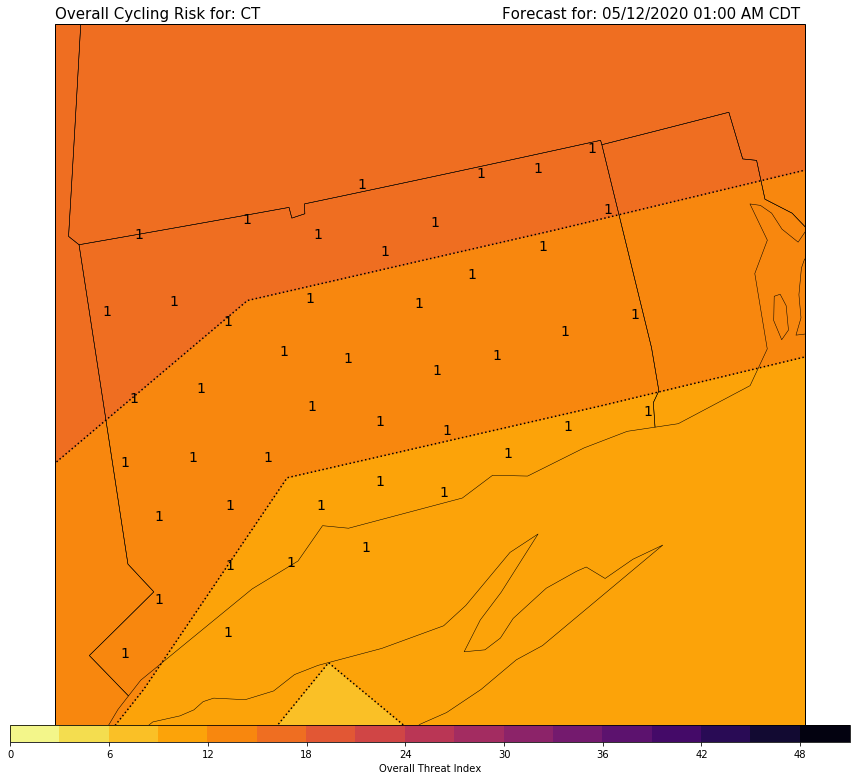

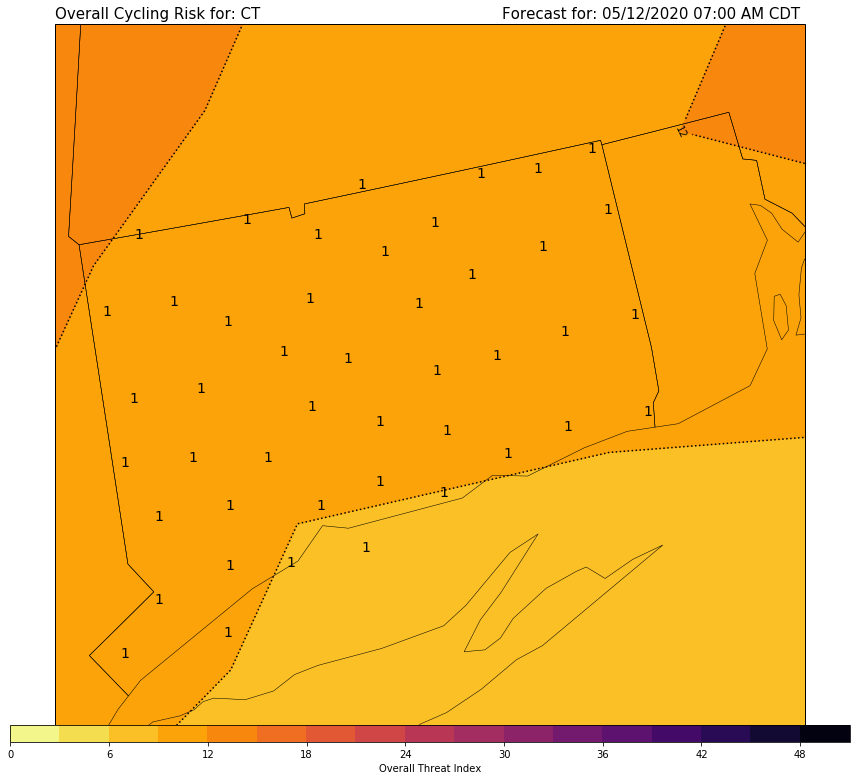

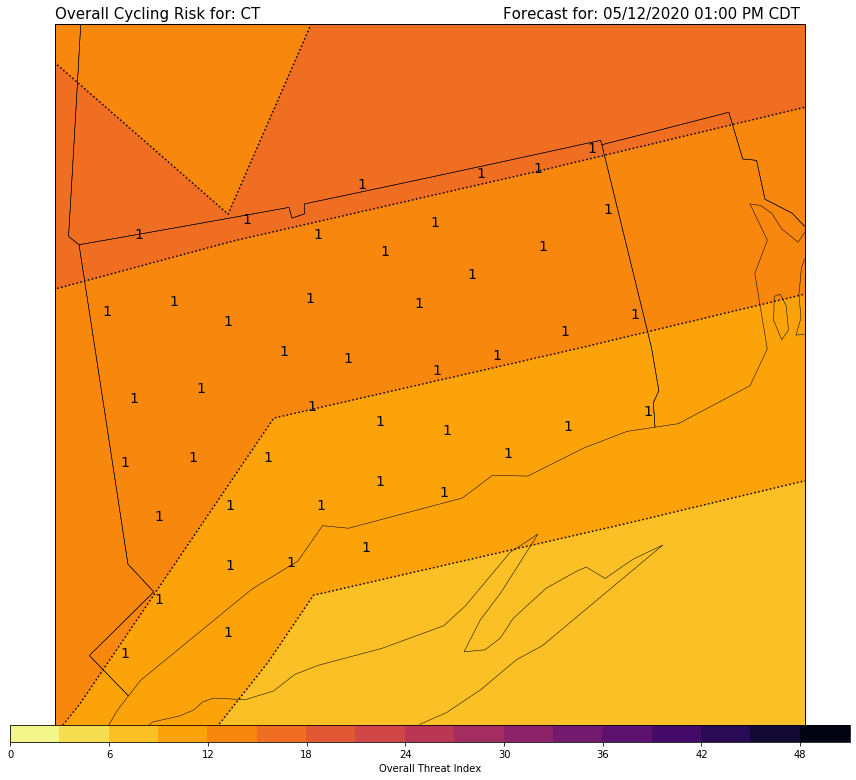

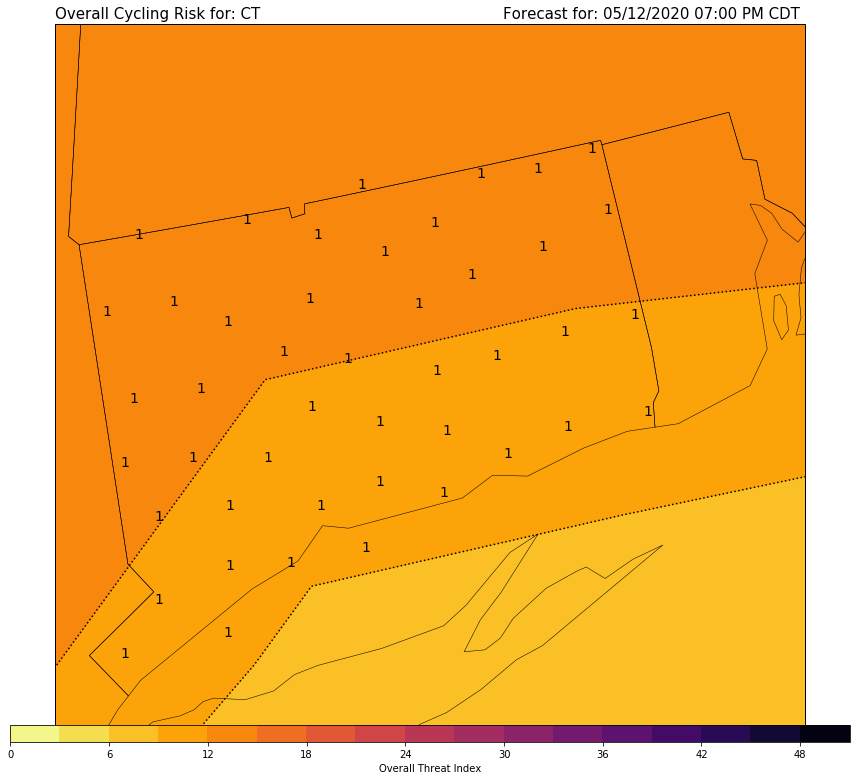

In [38]:
# Use the cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 300km radius

point_locs = mapcrs.transform_points(ccrs.PlateCarree(), state_landar['INTPTLONG'].values, state_landar['INTPTLAT'].values)
df_reduce = state_landar[reduce_point_density(point_locs,15* units.km)]

for FH in range(5,len(run_times)):
    #for FH in range(9,13):
    fig = plt.figure(1, figsize=map_size)
    ax = fig.add_subplot(111,projection=mapcrs)
    ax.set_extent(map_ext)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)

        # Plot values by coordinates
    stationplot = StationPlot(ax, lons.values, lats.values, clip_on=True, transform=datacrs, fontsize=12)

        # Plot values by coordinates
    stationplot = StationPlot(ax, df_reduce['INTPTLONG'].values, df_reduce['INTPTLAT'].values, clip_on=True,
                              transform=datacrs, fontsize=12)

    stationplot.plot_parameter('N',bike, fontsize=14, color = 'black')#'slategrey')
    stationplot.transform

        # Resample your data grid by a factor of 3 using cubic spline interpolation.



        #cmap=plt.cm.hot
    cf = ax.contourf(lons, lats, tbs3d[FH], range(0, 54, 3), cmap=plt.cm.inferno_r, transform=datacrs)
    cbar = plt.colorbar(cf, orientation='horizontal', aspect=50, pad=0, label = 'Overall Threat Index')



    cs = ax.contour(lons, lats, tbs3d[FH], range(0, 55, 3), colors='black', linestyles=':', transform=datacrs)
    plt.clabel(cs,fmt='%d')



    plt.title('Overall Cycling Risk for: '+ds_mpstate1.key_0[g],loc='Left', fontsize=15)
    plt.title('Forecast for: '+vtime_stamp(run_times[FH], time_list) , loc='right', fontsize=15)
    plt.savefig('/home/emazan/public_html/cycle_safe/'+ds_mpstate1.key_0[g]+'_BikeSafe_f{:03d}.png'.format(FH), bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()